In [2]:
import pandas as pd
import math
import numpy as np


# ファイルを読み込む
pd_reader = pd.read_csv("data_8.csv", encoding="ANSI")
df = pd_reader
df = df.dropna()
display(df)

,yyyymm,code,時価総額,PBR,翌1M収益率
0,200010,1301,1.563303e+10,14.687101,5.797101
2,200010,1332,4.962064e+10,0.652309,0.000000
3,200010,1333,3.690000e+10,1.610369,13.008130
5,200010,1352,3.088470e+09,6.920726,7.792208
6,200010,1377,1.020000e+11,1.207365,-1.755266
...,...,...,...,...,...
429890,202012,9991,3.497868e+10,0.626317,-1.875000
429891,202012,9993,1.914856e+10,0.676529,0.000000
429892,202012,9994,2.360497e+10,0.738982,-0.459559
429893,202012,9995,1.189206e+10,0.481392,9.555556


In [3]:
import math
# 時間推移関数
def nextym(yyyymm):
    yyyymm = yyyymm + 1
    if yyyymm % 100 == 13:
        yyyymm = yyyymm + 88
    return yyyymm

# Ｔ検定関数
def student(x_bar, y_bar, var_x, var_y, n_x, n_y):
    T = (x_bar - y_bar) / math.sqrt(var_x/n_x + var_y/n_y)
    print(T)
    if T > 2:
        print('有意差あり')
    else:
        print('有意差なし')
    return

# 時価加重収益率の計算関数
def rtncalculation(matrix):
    
    capitalization = matrix.loc[:, '時価総額']
    
    #収益率の抽出
    overall_rtn = matrix.loc[:, '翌1M収益率']
    overall_rtn = overall_rtn.values
    
    #時価加重ウェイトの計算
    weight = capitalization / sum(capitalization)
    weight = weight.values
    
    #収益率の計算
    rtn = np.dot(weight, overall_rtn)
    return rtn

In [4]:
#マーケット効果検証
mkt = 0
MKT = []
RTN = []
yyyymm = 200010

while yyyymm < 202012:
    tmp = df[df['yyyymm'] == yyyymm]

    capitalization = tmp.loc[:, '時価総額']
    
    # 収益率の抽出
    overall_rtn = tmp.loc[:, '翌1M収益率']
    overall_rtn = overall_rtn.values
    
    # 時価加重ウェイトの計算
    weight = capitalization / sum(capitalization)
    weight = weight.values
    
    # 収益率の計算
    rtn = np.dot(weight, overall_rtn)
    RTN.append(rtn) 
    
    mkt = mkt + rtn 
    MKT.append(mkt)
    
    yyyymm = nextym(yyyymm)

In [8]:
yyyymm = 200010
SMB_top = []
SMB_bot = []
HML_top = []
HML_bot = []
sample = 0
SMB = []
HML = []
smb_overall = []
hml_overall = []
smb = 0
hml = 0
# 分位点計算
top_pbr = df.loc[:, 'PBR'].quantile(q=0.7)
bot_pbr = df.loc[:, 'PBR'].quantile(q=0.3)
mid_cap = df.loc[:, '時価総額'].quantile(q=0.5)
print('top pbr 0.7 quantile:',top_pbr,'\nbot pbr 0.3 quantile:',bot_pbr,'\ncapitalization 0.5 quantile:',mid_cap)

while yyyymm < 202012:
    #時間設定
    tmp = df[df['yyyymm'] == yyyymm]

    # top PBR
    # PBR > 7分位点
    tmp_top = tmp[tmp.PBR >= top_pbr]
    # 時価総額 > 50% && PBR > 7分位
    top_pbr_top_cap = tmp_top[tmp_top.時価総額 >= mid_cap]
    # 時価総額 < 50% && PBR > 7分位
    top_pbr_bot_cap = tmp_top[tmp_top.時価総額 <= mid_cap]
    # 平均を求める
    top_rtn0 = rtncalculation(top_pbr_top_cap)
    top_rtn1 = rtncalculation(top_pbr_bot_cap)

    # mid PBR
    # 7分位 > PBR > 3分位
    tmp_mid = tmp[tmp.PBR >= bot_pbr]
    tmp_mid = tmp_mid[tmp_mid.PBR <= top_pbr]
    # 時価総額 > 50% && 7分位 > PBR > 3分位
    mid_pbr_top_cap = tmp_mid[tmp_mid.時価総額 >= mid_cap]
    # 時価総額 < 50% && 7分位 > PBR > 3分位
    mid_pbr_bot_cap = tmp_mid[tmp_mid.時価総額 <= mid_cap]
    # 平均を求める
    mid_rtn0 = rtncalculation(mid_pbr_top_cap)
    mid_rtn1 = rtncalculation(mid_pbr_bot_cap)


    # bot PBR
    # PBR < 3分位
    tmp_bot = tmp[tmp.PBR <= bot_pbr]
    # 時価総額 > 50% && PBR < 3分位
    bot_pbr_top_cap = tmp_bot[tmp_bot.時価総額 >= mid_cap]
    # 時価総額 < 50% && PBR < 3分位
    bot_pbr_bot_cap = tmp_bot[tmp_bot.時価総額 <= mid_cap]
    # 平均を求める
    bot_rtn0 = rtncalculation(bot_pbr_top_cap)
    bot_rtn1 = rtncalculation(bot_pbr_bot_cap)
    
    # SMB
    SMB_tmp = (bot_rtn1 + mid_rtn1 + top_rtn1)/3 - (bot_rtn0 + mid_rtn0 + top_rtn0)/3
    smb = smb + SMB_tmp
    SMB.append(smb)
    SMB_top.append((bot_rtn0 + mid_rtn0 + top_rtn0)/3)
    SMB_bot.append((bot_rtn1 + mid_rtn1 + top_rtn1)/3)
    
    # HML
    HML_tmp = (bot_rtn0 + bot_rtn1 - top_rtn0 - top_rtn1)/2
    hml = hml + HML_tmp
    HML.append(hml)
    HML_bot.append((bot_rtn0 + bot_rtn1)/2)
    HML_top.append((top_rtn0 + top_rtn1)/2)
    
    smb_overall.append(SMB_tmp)
    hml_overall.append(HML_tmp)
    
    yyyymm = nextym(yyyymm)
    sample = sample + 1

print('サンプル数:',sample)
print('マーケット平均:',pd.Series(RTN).mean(),'マーケット標準偏差',pd.Series(RTN).std())
print('SMB平均:',pd.Series(smb_overall).mean(),'SMB標準偏差:',pd.Series(smb_overall).std())
print('HML平均:',pd.Series(hml_overall).mean(),'SMB標準偏差:',pd.Series(hml_overall).std())

student(pd.Series(SMB_bot).mean(), pd.Series(SMB_top).mean(), pd.Series(SMB_bot).var(), pd.Series(SMB_top).var(), sample, sample)
student(pd.Series(HML_bot).mean(), pd.Series(HML_top).mean(), pd.Series(HML_bot).var(), pd.Series(HML_top).var(), sample, sample)

top pbr 0.7 quantile: 2.6492094433999998 
bot pbr 0.3 quantile: 0.8256734147999999 
capitalization 0.5 quantile: 47069997876.0
サンプル数: 242
マーケット平均: 0.29232573658939043 マーケット標準偏差 4.922610390542262
SMB平均: 0.48794691871869506 SMB標準偏差: 2.6455997717254633
HML平均: 0.34785801563587815 SMB標準偏差: 1.9857451158900585
1.060109370974284
有意差なし
0.740558182647325
有意差なし


In [6]:
from scipy import stats
list1 = pd.Series(SMB_bot)
list2 = pd.Series(SMB_top)
levene = stats.levene(list1, list2, center='median')
print(stats.stats.ttest_ind(list1, list2, equal_var=True))

C:\Users\apple\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Ttest_indResult(statistic=1.0601093709742837, pvalue=0.2896257702812248)


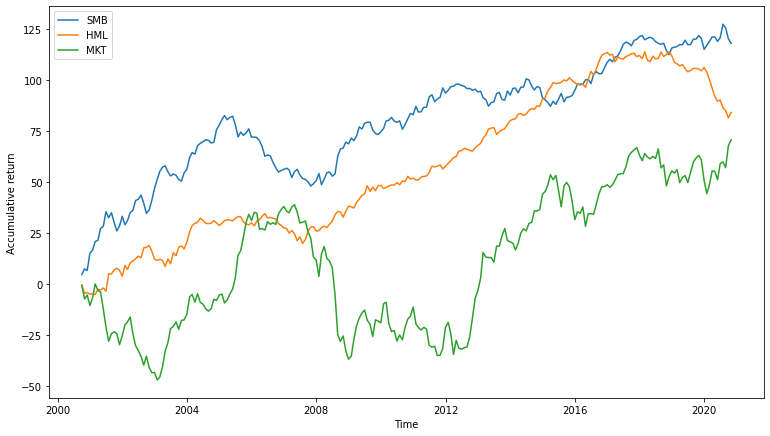

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(12.8, 7.2)
x=pd.date_range('2000-09-01','2020-11-01',freq='M')
y1 = SMB
y2 = HML
y3 = MKT
pic = plt.plot(x,y1,x,y2,x,y3)

plt.xlabel("Time")
plt.ylabel("Accumulative return")
plt.legend(["SMB","HML","MKT"],shadow=False,fancybox="blue")
plt.show()